# BenchMark de Modelos

***Para esse problema serão testados dois algoritmos distintos***
+ **O primeiro é o xgboost que é muito bom para tarefas desse tipo**
+ **O segundo uma rede neural utilizando keras**
+ **Após isso um teste de significância para determinar se a diferença no desempenho dos modelos é estatisticamente significativa**

In [1]:
#Bibliotecas Necessárias
from funcoes import *
from utilidades import *
import yaml
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import sklearn.metrics as mt 
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.metrics import AUC
import numpy as np
import xgboost as xgb
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 15,6

## Extração e tratamento dos dados

In [2]:
df = fetch_data_from_db(const.consulta_sql)
df

Função fetch_data_from_db executada em 1.57 segundos 


,profissao,tempoprofissao,renda,tiporesidencia,escolaridade,score,idade,dependentes,estadocivil,produto,valorsolicitado,valortotalbem,classe
0,Cientista de Dados,24,58660.0,Outros,Ens.Médio,MuitoBom,58.0,0,Solteiro,VoyageRoamer,84623.00,350000.00,bom
1,Empresário,21,46557.0,Outros,Ens.Médio,MuitoBom,37.0,2,Víuvo,EcoPrestige,126855.00,500000.00,bom
2,Dentista,13,43939.0,Própria,Ens.Médio,Bom,23.0,0,Casado,DoubleDuty,127151.00,320000.00,ruim
3,Engenheiro,10,37262.0,Própria,Superior,Baixo,35.0,0,Divorciado,AgileXplorer,28767.00,250000.00,bom
4,Contador,6,52606.0,Própria,PósouMais,Justo,27.0,0,Casado,TrailConqueror,199564.00,400000.00,ruim
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Médico,36,47480.0,Própria,Superior,Bom,64.0,0,Divorciado,SpeedFury,217011.00,800000.00,bom
146,Advogado,39,20860.0,Alugada,Ens.Fundamental,Bom,37.0,0,Víuvo,DoubleDuty,139244.00,320000.00,ruim
147,Arquiteto,26,31394.0,Própria,PósouMais,MuitoBom,53.0,1,Divorciado,ElegantCruise,107035.00,300000.00,ruim
148,Médico,19,39769.0,None,Ens.Médio,Baixo,64.0,0,Solteiro,VoyageRoamer,54520.00,350000.00,bom


In [3]:
#Preparação do conjunto de dados com as funções do módulo criado "funcoes"
profissoes_validas = ['Cientista de Dados', 'Empresário', 'Dentista', 'Engenheiro', 'Contador',
 'Arquiteto', 'Programador', 'Advogado', 'Médico' ]
corrigir_erros_digitacao(df, "profissao", profissoes_validas)
tratar_outliers(df, "idade", 17, 110)
tratar_outliers(df, "tempoprofissao", 0, 70)
substitui_nulos(df)

X = df.drop('classe', axis = 1)
y = df['classe']

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3, random_state = 1235)

#Carregamento dos padronizadores
X_teste = save_scalers(X_teste,['tempoprofissao','renda','idade','dependentes','valorsolicitado','valortotalbem'] )
X_treino = save_scalers(X_treino,['tempoprofissao','renda','idade','dependentes','valorsolicitado','valortotalbem'] )

#Carregamento dos Codificadores
X_treino = save_encoders(X_treino, ['profissao', 'tiporesidencia',  'escolaridade','score','estadocivil','produto'])
X_teste = save_encoders(X_teste, ['profissao', 'tiporesidencia',  'escolaridade','score','estadocivil','produto'])

#Carregamento do Seletor de Atributos
seletor = RFE(RandomForestClassifier(n_estimators=500), n_features_to_select=6, step=1)
X_treino = seletor.fit(X_treino, y_treino).transform(X_treino)
X_teste = seletor.transform(X_teste)

#Codificação Manual (Ruim receberá 0 e Bom receberá 1)
mapeamento = {'ruim' : 0, 'bom' : 1}
y_treino = np.array([mapeamento[item] for item in y_treino])
y_teste = np.array([mapeamento[item] for item in y_teste])

Função corrigir_erros_digitacao executada em 0.00 segundos 
Função tratar_outliers executada em 0.00 segundos 
Função tratar_outliers executada em 0.02 segundos 
Função substitui_nulos executada em 0.01 segundos 
Função save_scalers executada em 0.07 segundos 
Função save_scalers executada em 0.06 segundos 
Função save_encoders executada em 0.02 segundos 
Função save_encoders executada em 0.01 segundos 


## XGB Classifier

In [4]:
# Configurando o modelo XGBoost
xgb_model = xgb.XGBClassifier(eval_metric="logloss", verbosity=1)

# Definição dos hiperparâmetros para RandomizedSearchCV
param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [3, 5, 7],    
    "gamma": np.linspace(0, 0.5, 5),
    "min_child_weight": [1, 3, 5, 7],
    "subsample": np.linspace(0.6, 1.0),
    "colsample_bytree": np.linspace(0.6, 1.0, 5),
    "scale_pos_weight": [1, 5, 10, 15, 25]  # Ajustando o peso da classe minoritária
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, 
    n_iter=64, scoring="roc_auc", cv=5, verbose=2, n_jobs=-1, random_state=42
)

# Ajustando os parâmetros
random_search.fit(X_treino, y_treino)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
       0.76326531, 0.77142857, 0.77959184, 0.7877551 , 0.79591837,
       0.80408163, 0.8122449 , 0.82040816, 0.82857143, 0.83673469,
       0.84489796, 0.85306122, 0.86122449, 0.86938776, 0.87755102,
       0.88571429, 0.89387755, 0.90204082, 0.91020408, 0.91836735,
       0.92653061, 0.93469388, 0.94285714, 0.95102041, 0.95918367,
       0.96734694, 0.9755102 , 0.98367347, 0.99183673, 1.        ])},
                   random_state=42, scoring='roc_auc', verbose=2)

In [5]:
# Melhor combinação encontrada
print("Melhores parâmetros:", random_search.best_params_)

Melhores parâmetros: {'subsample': 0.9918367346938776, 'scale_pos_weight': 10, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 7, 'gamma': 0.0, 'colsample_bytree': 0.7}


### Métricas XGB Classifier

In [6]:
#Algumas métricas adicionais para conferir a acurácia do modelo nos dados de teste
model_xgb = random_search.best_estimator_
y_pred = model_xgb.predict(X_teste)

accuracy = mt.accuracy_score(y_teste, y_pred)
print(f'Acurácia do modelo nos dados de teste: {accuracy}')

print(mt.classification_report(y_teste, y_pred))

confusion_matrix_xgb = mt.confusion_matrix(y_teste, y_pred)
print(f'Matriz de confusão:\n {confusion_matrix_xgb} \n ')

Acurácia do modelo nos dados de teste: 0.8222222222222222
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.81      0.88      0.85        25

    accuracy                           0.82        45
   macro avg       0.82      0.81      0.82        45
weighted avg       0.82      0.82      0.82        45

Matriz de confusão:
 [[15  5]
 [ 3 22]] 
 


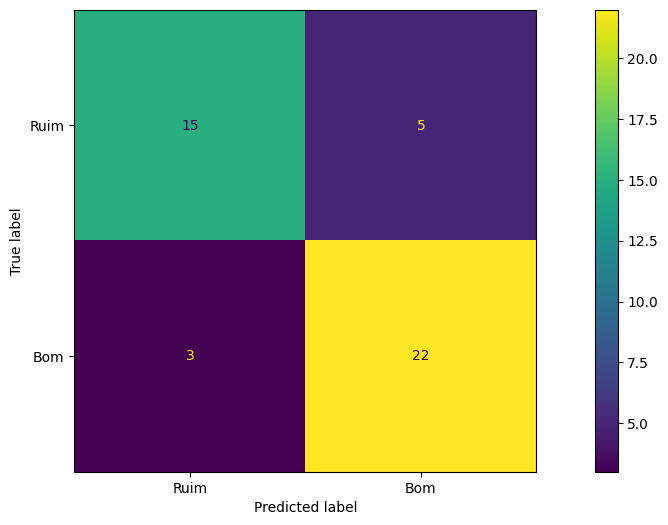

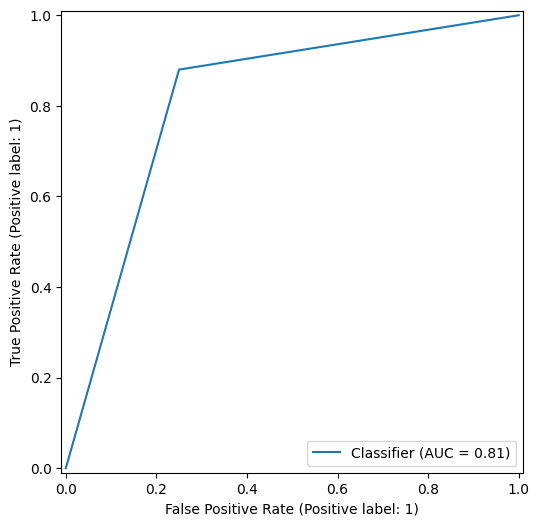

In [7]:
confusion_xgb = mt.ConfusionMatrixDisplay(confusion_matrix_xgb, display_labels=["Ruim", "Bom"])
confusion_xgb.plot()

roc_xgb = mt.RocCurveDisplay.from_predictions(y_teste, y_pred )

## Sequential

In [8]:
#Empilhamento das camadas das redes neurais
model_seq = Sequential()
model_seq.add(Dense(50, activation = 'relu', input_dim = X_treino.shape[1]))
model_seq.add(Dropout(0.2))
model_seq.add(Dense(50, activation = 'relu'))
model_seq.add(Dropout(0.2))
model_seq.add(Dense(50, activation = 'relu'))
model_seq.add(Dropout(0.2))
model_seq.add(Dense(1, activation = 'sigmoid'))

model_seq.summary()

#Compilação e treinamento
model_seq.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [AUC()])
early_stopping = EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, mode="min")
model_seq.fit(X_treino, y_treino, epochs = 500, batch_size = 20, validation_data=(X_teste, y_teste), callbacks=[early_stopping])

previsoes = model_seq.predict(X_teste)

previsoes = (previsoes > 0.5).astype(int)

C:\Users\roni_\anaconda3\envs\ambiente_streamlit\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,501 (21.49 KB)

 Trainable params: 5,501 (21.49 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - auc: 0.5218 - loss: 0.7096 - val_auc: 0.3430 - val_loss: 0.7140
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - auc: 0.5556 - loss: 0.6779 - val_auc: 0.4460 - val_loss: 0.6989
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.5382 - loss: 0.6797 - val_auc: 0.5070 - val_loss: 0.6912
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.5740 - loss: 0.6660 - val_auc: 0.5620 - val_loss: 0.6909
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - auc: 0.6430 - loss: 0.6503 - val_auc: 0.5700 - val_loss: 0.6916
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.6743 - loss: 0.6393 - val_auc: 0.5780 - val_loss: 0.6937
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.6217 - loss: 0.6269 - val_auc: 0.5980 - val_loss: 0.6957
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.7498 - loss: 0.6312 - val_auc: 0.5970 - val_loss: 0.6969
Epoch 9/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.6834 - loss:

### Métricas Sequential

In [9]:
#Algumas métricas adicionais para conferir a acurácia do modelo nos dados de teste
accuracy = mt.accuracy_score(y_teste, previsoes)
print(f'Acurácia do modelo nos dados de teste: {accuracy}')

report = mt.classification_report(y_teste, previsoes)
print(f'Outras métricas do modelo com os dados de teste: \n  {report}')

confusion_matrix_seq = mt.confusion_matrix(y_teste, previsoes)
print(f'Matriz de confusão: \n  {confusion_matrix_seq} \n ')

Acurácia do modelo nos dados de teste: 0.9333333333333333
Outras métricas do modelo com os dados de teste: 
                precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.92      0.96      0.94        25

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45

Matriz de confusão: 
  [[18  2]
 [ 1 24]] 
 


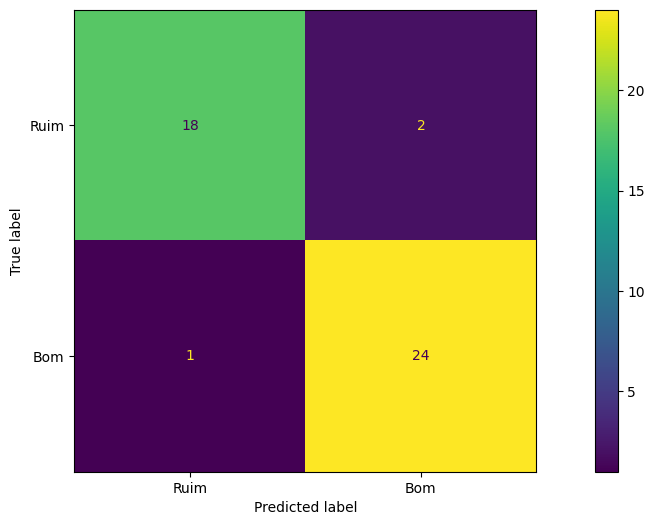

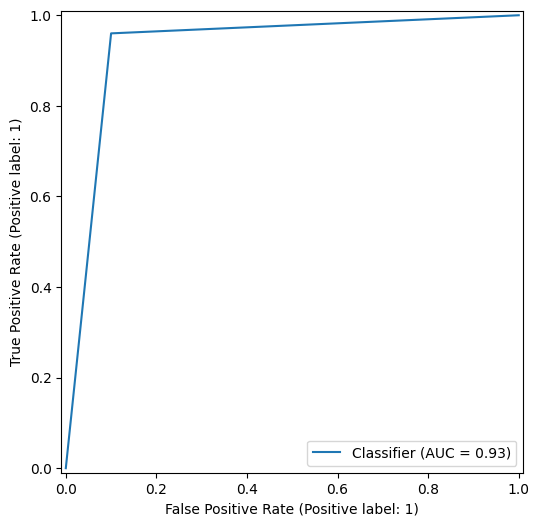

In [10]:
confusion_seq = mt.ConfusionMatrixDisplay(confusion_matrix_seq, display_labels=["Ruim", "Bom"])
confusion_seq.plot()

roc_xgb = mt.RocCurveDisplay.from_predictions(y_teste, previsoes)

## Teste estatístico

In [11]:
y_prob_xgb = model_xgb.predict_proba(X_teste) # Previsões do XGB vem em formato diferente
y_prob_seq = model_seq.predict(X_teste) # Previsões do Sequential já vem em probabilidades (camada de saída Sigmoid)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [12]:
# Primeiras 10 previsões do modelo XGBoost para simples comparação
y_prob_xgb = np.array(y_prob_xgb[:,1]).ravel().reshape(-1) #Pega a coluna 2 que corresponde às probabilidades corretas do Sequential
y_prob_xgb[:10]

array([0.06286344, 0.9186196 , 0.97457415, 0.2968355 , 0.16266698,
       0.03039519, 0.4505155 , 0.36468664, 0.15604533, 0.98948973],
      dtype=float32)

In [13]:
# Primeiras 10 previsões do modelo sequential para comparação das previsões
y_prob_seq = y_prob_seq.reshape(-1)
y_prob_seq[:10]

array([0.15384132, 0.12936766, 0.91546595, 0.23527473, 0.43707293,
       0.19151413, 0.30189914, 0.29239157, 0.10620224, 0.9983065 ],
      dtype=float32)

In [14]:
t_statistic, p_value = ttest_rel(y_prob_xgb, y_prob_seq)

print(f"Estatística t: {t_statistic:.4f}")
print(f"Valor p: {p_value:.4f}")

# Interpretação do resultado
alpha = 0.05
if p_value < alpha:
    print("🔬 A diferença entre os modelos é estatisticamente significativa!")
else:
    print("⚠️ Não há evidências estatísticas suficientes para afirmar que a diferença é significativa.")


Estatística t: 1.2020
Valor p: 0.2358
⚠️ Não há evidências estatísticas suficientes para afirmar que a diferença é significativa.


In [15]:
# Salvamento das matrizes para uso em produção
np.save('objects/confusion_xgb.npy', confusion_matrix_xgb)
np.save("objects/confusion_seq.npy", confusion_matrix_seq)

## Explicabilidade

In [16]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.provider import InlineProvider
from interpret import show
from sklearn.metrics import accuracy_score
from joblib import load

seletor = load("objects/seletor.joblib") # Carregamento do seletor de atributos

In [17]:
# Colunas selecionadas para utilização no modelo
print(seletor.support_)

[False  True  True False False  True  True False False False  True  True]


In [18]:
df_prev = df[df.columns.drop("classe")[seletor.support_]] # Pega as colunas mais importante selecionadas por RFE
df_prev

,tempoprofissao,renda,score,idade,valorsolicitado,valortotalbem
0,24.0,58660.0,MuitoBom,58.0,84623.00,350000.00
1,21.0,46557.0,MuitoBom,37.0,126855.00,500000.00
2,13.0,43939.0,Bom,23.0,127151.00,320000.00
3,10.0,37262.0,Baixo,35.0,28767.00,250000.00
4,6.0,52606.0,Justo,27.0,199564.00,400000.00
...,...,...,...,...,...,...
145,36.0,47480.0,Bom,64.0,217011.00,800000.00
146,39.0,20860.0,Bom,37.0,139244.00,320000.00
147,26.0,31394.0,MuitoBom,53.0,107035.00,300000.00
148,19.0,39769.0,Baixo,64.0,54520.00,350000.00


In [19]:
ebc = ExplainableBoostingClassifier()
ebc.fit(df_prev, df["classe"])

ExplainableBoostingClassifier()

In [20]:
# Avaliando o modelo
y_pred = ebc.predict(df_prev)
print("Acurácia do Modelo:", accuracy_score(df["classe"], y_pred))

Acurácia do Modelo: 0.9733333333333334


**A acurácia acima foi calculada utilizando o mesmo conjunto de dados para treino e teste, e serve apenas para medir a confiança do modelo de interpretabilidade**

In [21]:
global_explanation = ebc.explain_global()
show(global_explanation)

<!-- http://127.0.0.1:7001/2435095386480/ -->

In [22]:
local_explanation = ebc.explain_local(df_prev.loc[15:20,:], df.loc[15:20, "classe"])
show(local_explanation)

<!-- http://127.0.0.1:7001/2433339745280/ -->